<div class="alert alert-block" style="border: 2px solid #1976D2;background-color:#E3F2FD;padding:5px;font-size:0.9em;">
본 자료는 저작권법 제25조 2항에 의해 보호를 받습니다. 본 자료를 외부에 공개하지 말아주세요.<br>
<b><a href="https://school.fun-coding.org/">잔재미코딩 (https://school.fun-coding.org/)</a> 에서 본 강의를 포함하는 최적화된 로드맵도 확인하실 수 있습니다</b></div>

### PyTorch 의 Pre-Trained Models

> Transfer Learning 은 관련 기능들이 아직 안정화되지는 않은 상태임 
> 현재까지 안정된 모델을 중심으로 사용해보도록 함

### Pre-Trained 모델 사용하기
- torchvision.models 에 이미지/비디오 관련 다양한 모델을 제공함
   - https://pytorch.org/vision/stable/models.html
   - 하지만, 사용법이 수시로 변하고, 환경마다 에러가 나는 케이스가 있어서 불안정

- timm 라이브러리
  - https://timm.fast.ai/
  - torchvision 보다 최신 모델을 사용해볼 수 있음
  - 여러 SOTA(State-Of-The-Art) models 제공
  - torchvision 보다 최신 모델, 가중치 업데이트 및 일부 모델에서 공식 추천
  - torchvision 보다 가중치가 알맞게 최적화된 케이스가 많음
    - 일부 모델은 가중치값을 가져오지 못하고, 에러를 낼 수도 있음

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import numpy as np
from copy import deepcopy

### timm 사용법

In [2]:
!pip install timm

In [3]:
import timm
model_names = timm.list_models(pretrained=True)
print (model_names)

['adv_inception_v3', 'bat_resnext26ts', 'beit_base_patch16_224', 'beit_base_patch16_224_in22k', 'beit_base_patch16_384', 'beit_large_patch16_224', 'beit_large_patch16_224_in22k', 'beit_large_patch16_384', 'beit_large_patch16_512', 'botnet26t_256', 'cait_m36_384', 'cait_m48_448', 'cait_s24_224', 'cait_s24_384', 'cait_s36_384', 'cait_xs24_384', 'cait_xxs24_224', 'cait_xxs24_384', 'cait_xxs36_224', 'cait_xxs36_384', 'coat_lite_mini', 'coat_lite_small', 'coat_lite_tiny', 'coat_mini', 'coat_tiny', 'convit_base', 'convit_small', 'convit_tiny', 'convmixer_768_32', 'convmixer_1024_20_ks9_p14', 'convmixer_1536_20', 'convnext_base', 'convnext_base_384_in22ft1k', 'convnext_base_in22ft1k', 'convnext_base_in22k', 'convnext_large', 'convnext_large_384_in22ft1k', 'convnext_large_in22ft1k', 'convnext_large_in22k', 'convnext_nano', 'convnext_small', 'convnext_small_384_in22ft1k', 'convnext_small_in22ft1k', 'convnext_small_in22k', 'convnext_tiny', 'convnext_tiny_384_in22ft1k', 'convnext_tiny_hnf', 'conv

### Pre-Trained 모델 검색

In [5]:
print (timm.list_models('*vit_base*'))

['convit_base', 'crossvit_base_240', 'vit_base_patch8_224', 'vit_base_patch8_224_dino', 'vit_base_patch8_224_in21k', 'vit_base_patch16_18x2_224', 'vit_base_patch16_224', 'vit_base_patch16_224_dino', 'vit_base_patch16_224_in21k', 'vit_base_patch16_224_miil', 'vit_base_patch16_224_miil_in21k', 'vit_base_patch16_224_sam', 'vit_base_patch16_384', 'vit_base_patch16_plus_240', 'vit_base_patch16_rpn_224', 'vit_base_patch32_224', 'vit_base_patch32_224_in21k', 'vit_base_patch32_224_sam', 'vit_base_patch32_384', 'vit_base_patch32_plus_256', 'vit_base_r26_s32_224', 'vit_base_r50_s16_224', 'vit_base_r50_s16_224_in21k', 'vit_base_r50_s16_384', 'vit_base_resnet26d_224', 'vit_base_resnet50_224_in21k', 'vit_base_resnet50_384', 'vit_base_resnet50d_224']


### create_model(모델명, pretrained=True)
   - pretrained=True 이면, 학습된 가중치도 가져옴
   - num_classes=10 등으로 out_features 를 변경할 수도 있음

<div class="alert alert-block" style="border: 2px solid #E65100;background-color:#FFF3E0;padding:10px">
<font size="4em" style="color:#BF360C;">Resnet 과 ViT(Vision Transformer)</font><br>
<font size="3em" >CNN 등장 후, CNN기반 모델(AlexNet, VGGNet, ResNet, DenseNet, NasNet, EfficientNet 등)이 주류를 이루었고, </font> <br>
<font size="3em" >SOTA(State-Of-The-Art)성능을 보여주었음. (이 중에 대표적인 CNN 기반 모델이 ResNet)</font> <br>
<font size="3em" >이런 상황에서, 2021년에 Vision Transformer가 등장하며 ImageNet기준 1, 2위를 차지함</font> <br>
<font size="3em" >Vision Transformer 는 최신 자연어 처리 분야에서 가장 좋은 성능을 보여주는 Transformer 라는 개념을 Vision 분야에 적용하여, </font> <br>
<font size="3em" >SOTA 성능을 보여주고 있는 최신 모델</font> <br>
<font size="3em" >해당 모델의 깊은 이해를 위해서는 Sequence-to-Sequence(Seq2Seq), Attention 이해 필요 (딥러닝 중급)</font>
</div>

<div class="alert alert-block" style="border: 2px solid #E65100;background-color:#FFF3E0;padding:10px">
<font size="4em" style="color:#BF360C;">Resnet34, 50, 101</font><br>
<font size="3em" >34, 50, 101 은 레이어 수로 이해하면 됨</font> <br>
<font size="3em" >Google colab 에서조차 34 레이어로도 학습에 상당한 시간이 걸리므로, 우선 가볍게 resnet34 로 MNIST를 테스트해보며 </font> <br>
<font size="3em" >Transfer Learning 과 관련 사용법에 익숙해지도록 함</font>
</div>

In [5]:
import timm

# create_model(모델명, pretrained=True, in_chans=1, num_calsses=10)
model = timm.create_model("resnet50", pretrained=True,  in_chans=1, num_classes=10)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


In [6]:
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

<div class="alert alert-block" style="border: 2px solid #E65100;background-color:#FFF3E0;padding:10px">
<font size="4em" style="color:#BF360C;">다양한 모델 변경 가능</font><br>
<pre>
# 모델 변경, 직접 특정 layer 의 파라미터를 변경할 수도 있음
model.classifier[6].out_features = 10
# layer 추가 (파이썬 문법으로 자유자재로 할 수 있음)
last_layer_for10 = nn.Linear(1000, 10, bias=True)
final_activation = nn.LogSoftmax(dim=-1)
model.classifier.append(last_layer_for10)
final_activation = nn.LogSoftmax(dim=-1)
model.classifier.append(final_activation)
    </pre>
</div>

In [7]:
model.fc = (
    nn.Sequential(
        nn.Linear(2048, 10, bias=True),
        nn.LogSoftmax(dim=-1)
    )
)
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

### Pre-Trained Model 의 freeze 기법
- 선택적으로 레이어별 가중치 업데이트 또는 freeze 가능

```python
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True
```

### MNIST with Transfer Learning

<div class="alert alert-block" style="border: 2px solid #E65100;background-color:#FFF3E0;padding:10px">
<font size="4em" style="color:#BF360C;">Resnet 등은 보통 3채널 224x224 이미지로 학습되어 있음</font><br>
<font size="3em" >MNIST 는 1채널 28x28 이므로, Fine Tuning 이 필요할 정도이지만, </font> <br>
<font size="3em" >Google colab 에서조차 학습에 상당한 시간이 걸리므로, 우선 가볍게 resnet34 로 MNIST를 테스트해보며 </font> <br>
<font size="3em" >Transfer Learning 과 관련 사용법에 익숙해지도록 함</font>
</div>

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)
print (device)

model = model.to(device)

cuda


In [10]:
train_rawdata = datasets.MNIST(root = 'dataset',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root = 'dataset',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())
print('number of training data : ', len(train_rawdata))
print('number of test data : ', len(test_dataset))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw

number of training data :  60000
number of test data :  10000


In [11]:
VALIDATION_RATE = 0.2
train_indices, val_indices = train_test_split(
    range(len(train_rawdata)), # X index 번호
    stratify=train_rawdata.targets, # 균등분포
    test_size=VALIDATION_RATE # test dataset 비율
)

In [12]:
train_dataset = Subset(train_rawdata, train_indices)
validation_dataset = Subset(train_rawdata, val_indices)

In [13]:
print (len(train_dataset), len(validation_dataset), len(test_dataset))

48000 12000 10000


In [14]:
minibatch_size = 128 # Mini-batch 사이즈는 128 로 설정
# create batches
train_batches = DataLoader(train_dataset, batch_size=minibatch_size, shuffle=True)
val_batches = DataLoader(validation_dataset, batch_size=minibatch_size, shuffle=True)
test_batches = DataLoader(test_dataset, batch_size=minibatch_size, shuffle=False)

### input, output, loss, optimizer 설정
- L2 regularizaion 을 사용하기 위해 weight decay 값을 설정하면, 가중치 업데이트가 학습데이터셋에 overfit 되지 않도록 가중치 업데이트를 완화하는 효과를 볼 수 있음
- 하지만 Adam 은 계산식(gradient 제곱 누적 값의 역수에 루트를 취한 것으로 learning rate을 나눠 줌)에 weight decay 값이 포함되면, 계산식에 의해 각 step 별 weight decay 의 영향이 달라질 수 있고, 해당 영향이 결국 작아질 수 있음 
- 따라서, AdamW 는 weight decay를 분리하여 별도로 적용하는 decoupled weight decay를 사용함
- 테스트셋에 대한 일반화 성능을 높이기 위해, AdamW 사용하는 케이스가 많아지고 있음

In [15]:
loss_func = nn.NLLLoss() # log softmax 는 NLLLoss() 로 진행해야 함
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.001) 

### Training & Validation

In [16]:
def train_model(model, early_stop, n_epochs, progress_interval):
    
    train_losses, valid_losses, lowest_loss = list(), list(), np.inf

    for epoch in range(n_epochs):
        
        train_loss, valid_loss = 0, 0
        
        # train the model
        model.train() # prep model for training
        for x_minibatch, y_minibatch in train_batches:
            x_minibatch = x_minibatch.to(device)
            y_minibatch = y_minibatch.to(device)              
            y_minibatch_pred = model(x_minibatch)
            loss = loss_func(y_minibatch_pred, y_minibatch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss = train_loss / len(train_batches)
        train_losses.append(train_loss)      
        
        # validate the model
        model.eval()
        with torch.no_grad():
            for x_minibatch, y_minibatch in val_batches:
                x_minibatch = x_minibatch.to(device)
                y_minibatch = y_minibatch.to(device)              
                y_minibatch_pred = model(x_minibatch)
                loss = loss_func(y_minibatch_pred, y_minibatch)
                valid_loss += loss.item()
                
        valid_loss = valid_loss / len(val_batches)
        valid_losses.append(valid_loss)

        if valid_losses[-1] < lowest_loss:
            lowest_loss = valid_losses[-1]
            lowest_epoch = epoch
            best_model = deepcopy(model.state_dict())
        else:
            if (early_stop > 0) and lowest_epoch + early_stop < epoch:
                print ("Early Stopped", epoch, "epochs")
                break
                
        if (epoch % progress_interval) == 0:
            print (train_losses[-1], valid_losses[-1], lowest_loss, lowest_epoch, epoch)
            
    model.load_state_dict(best_model)        
    return model, lowest_loss, train_losses, valid_losses

### 훈련 실행
<div class="alert alert-block" style="border: 2px solid #E65100;background-color:#FFF3E0;padding:10px">
<font size="4em" style="color:#BF360C;">CPU 만으로는 테스트 불가능에 가까움</font><br>
<font size="4em" style="color:#BF360C;">본 주피터 노트북 파일을 사용하여 colab 을 통한 테스트 추천</font>
</div>

In [17]:
nb_epochs = 100 
progress_interval = 1
early_stop = 30

model, lowest_loss, train_losses, valid_losses = train_model(model, early_stop, nb_epochs, progress_interval)

0.12479344755411148 0.06818947196006775 0.06818947196006775 0 0
0.01637871190905571 0.08782291412353516 0.027908360585570335 2 3
0.0032795732840895653 0.07414767891168594 0.010603182949125767 5 6
0.01255361270159483 0.13975508511066437 0.002649472327902913 8 9
0.0012841636780649424 0.0038356941659003496 0.0024218999315053225 11 12
0.005148268770426512 0.00039262312930077314 0.00039262312930077314 15 15
0.0005215435521677136 0.05675218626856804 0.00039262312930077314 15 18
0.00029053472098894417 0.05632275715470314 0.0002915102813858539 20 21
0.00012315150524955243 0.049336981028318405 2.8201722670928575e-05 22 24
0.00037161403452046216 0.027799153700470924 2.8201722670928575e-05 22 27
0.000314657372655347 0.005913644563406706 2.8201722670928575e-05 22 30
7.88506877142936e-05 0.0012339171953499317 2.8201722670928575e-05 22 33
0.004195365589112043 0.08803031593561172 2.8201722670928575e-05 22 36
2.957294782390818e-05 0.00307449814863503 2.8201722670928575e-05 22 39
0.0045267012901604176 

### 테스트셋 기반 Evaluation

In [18]:
test_loss = 0
correct = 0
wrong_samples, wrong_preds, actual_preds = list(), list(), list()

model.eval()
with torch.no_grad():
    for x_minibatch, y_minibatch in test_batches:
        x_minibatch = x_minibatch.to(device)
        y_minibatch = y_minibatch.to(device)      
        y_test_pred = model(x_minibatch)
        test_loss += loss_func(y_test_pred, y_minibatch)  
        pred = torch.argmax(y_test_pred, dim=1)
        correct += pred.eq(y_minibatch).sum().item()
        
        wrong_idx = pred.ne(y_minibatch).nonzero()[:, 0].cpu().numpy().tolist()
        for index in wrong_idx:
            wrong_samples.append(x_minibatch[index].cpu())
            wrong_preds.append(pred[index].cpu())
            actual_preds.append(y_minibatch[index].cpu())
            
test_loss /= len(test_batches.dataset)
print('Average Test Loss: {:.4f}'.format( test_loss ))
print('Accuracy: {}/{} ({:.2f}%)'.format( correct, len(test_batches.dataset), 100 * correct / len(test_batches.dataset) ))

Average Test Loss: 0.0002
Accuracy: 9948/10000 (99.48%)


### incorrect data 만 확인해보기

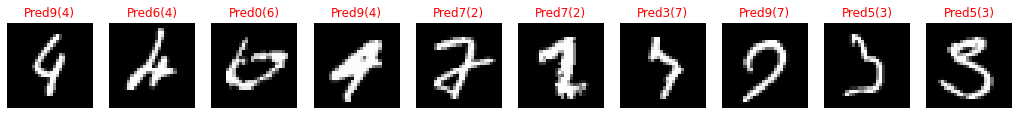

In [19]:
# incorrect 데이터 중, 100개 이미지만 출력해보기
import matplotlib.pyplot as plt
# 주피터 노트북에서 그림을 주피터 노트북 내에 표시하도록 강제하는 명령
%matplotlib inline 

plt.figure(figsize=(18 , 20))

for index in range(10):
    plt.subplot(10, 10, index + 1)
    plt.axis('off')
    plt.imshow(wrong_samples[index].numpy().reshape(28,28), cmap = "gray")
    plt.title("Pred" + str(wrong_preds[index].item()) + "(" + str(actual_preds[index].item()) + ")", color='red')

<div class="alert alert-block" style="border: 2px solid #1976D2;background-color:#E3F2FD;padding:5px;font-size:0.9em;">
본 자료는 저작권법 제25조 2항에 의해 보호를 받습니다. 본 자료를 외부에 공개하지 말아주세요.<br>
<b><a href="https://school.fun-coding.org/">잔재미코딩 (https://school.fun-coding.org/)</a> 에서 본 강의를 포함하는 최적화된 로드맵도 확인하실 수 있습니다</b></div>